In [1]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from cmdstanpy import CmdStanModel
import cmdstanpy
import arviz as az
import pandas as pd
import csv,re

from DA_tools.DA_tools import ribbon_plot
from DA_tools.FDA_data_prepare import create_spline_matrix
from DA_tools.DA_colors import *

plt.style.context("seaborn-white")
mpl.rcParams["figure.dpi"] = 200

In [2]:
LIGHT = "#B3FFFF"  # 179, 255, 255,
LIGHT_HIGHLIGHT = "#9AF6FF"  # 154, 246,255
MID = "#67C3FF"  # 103,195,255
MID_HIGHLIGHT = "#3490CC"  # 52,144,204
DARK = "#015D99"  # 1,93,153
DARK_HIGHLIGHT = "#002A66"  # 0,42,102
GREEN = "#00FF00"  # RGB
LIGHT_GREY = "#DDDDDD"  # RGB

In [3]:
acc_healthy = pd.read_csv('data_preprocesed/acc_healthy_samples.csv')
acc_damaged = pd.read_csv('data_preprocesed/acc_damaged_samples.csv')
acc_very_damaged = pd.read_csv('data_preprocesed/acc_very_damaged_samples.csv')

gyro_healthy = pd.read_csv('data_preprocesed/gyro_healthy_samples.csv')
gyro_damaged = pd.read_csv('data_preprocesed/gyro_damaged_samples.csv')
gyro_very_damaged = pd.read_csv('data_preprocesed/gyro_very_damaged_samples.csv')

gyro_agg_healthy = pd.read_csv('data_preprocesed/gyro_agg_healthy_samples.csv')
gyro_agg_damaged = pd.read_csv('data_preprocesed/gyro_agg_damaged_samples.csv')
gyro_agg_very_damaged = pd.read_csv('data_preprocesed/gyro_agg_very_damaged_samples.csv')

In [4]:
acc_healthy_data = np.array([acc_healthy[col].values for col in acc_healthy.columns if col.startswith('Sample')])
acc_damaged_data = np.array([acc_damaged[col].values for col in acc_damaged.columns if col.startswith('Sample')])
acc_v_damaged_data = np.array([acc_very_damaged[col].values for col in acc_very_damaged.columns if col.startswith('Sample')])
acc = [acc_healthy_data,acc_damaged_data,acc_v_damaged_data]

gyro_healthy_data = np.array([gyro_healthy[col].values for col in gyro_healthy.columns if col.startswith('Sample')])
gyro_damaged_data = np.array([gyro_damaged[col].values for col in gyro_damaged.columns if col.startswith('Sample')])
gyro_very_damaged_data = np.array([gyro_very_damaged[col].values for col in gyro_very_damaged.columns if col.startswith('Sample')])
gyro = [gyro_healthy_data,gyro_damaged_data,gyro_very_damaged_data]

gyro_agg_healthy_data = np.array([gyro_agg_healthy[col].values for col in gyro_agg_healthy.columns if col.startswith('Sample')])
gyro_agg_damaged_data = np.array([gyro_agg_damaged[col].values for col in gyro_agg_damaged.columns if col.startswith('Sample')])
gyro_agg_very_damaged_data = np.array([gyro_agg_very_damaged[col].values for col in gyro_agg_very_damaged.columns if col.startswith('Sample')])
gyro_agg = [gyro_agg_healthy_data, gyro_agg_damaged_data, gyro_agg_very_damaged_data]

Prior predictive check model 1

In [5]:
prior_model_1 = CmdStanModel(stan_file='stan/prior_check.stan')

In [6]:
num_knots = 15
N = 150
times = np.linspace(0,N*10,N)
knot_list = np.quantile(times,np.linspace(0,1,num_knots))
B0 = create_spline_matrix(N, times, 3, num_knots)

data_ppc = {
    "N": N,
    "K": num_knots+2,
    "X": B0
}
ppc_samples = prior_model_1.sample(data=data_ppc)

18:40:13 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:40:13 - cmdstanpy - INFO - CmdStan done processing.


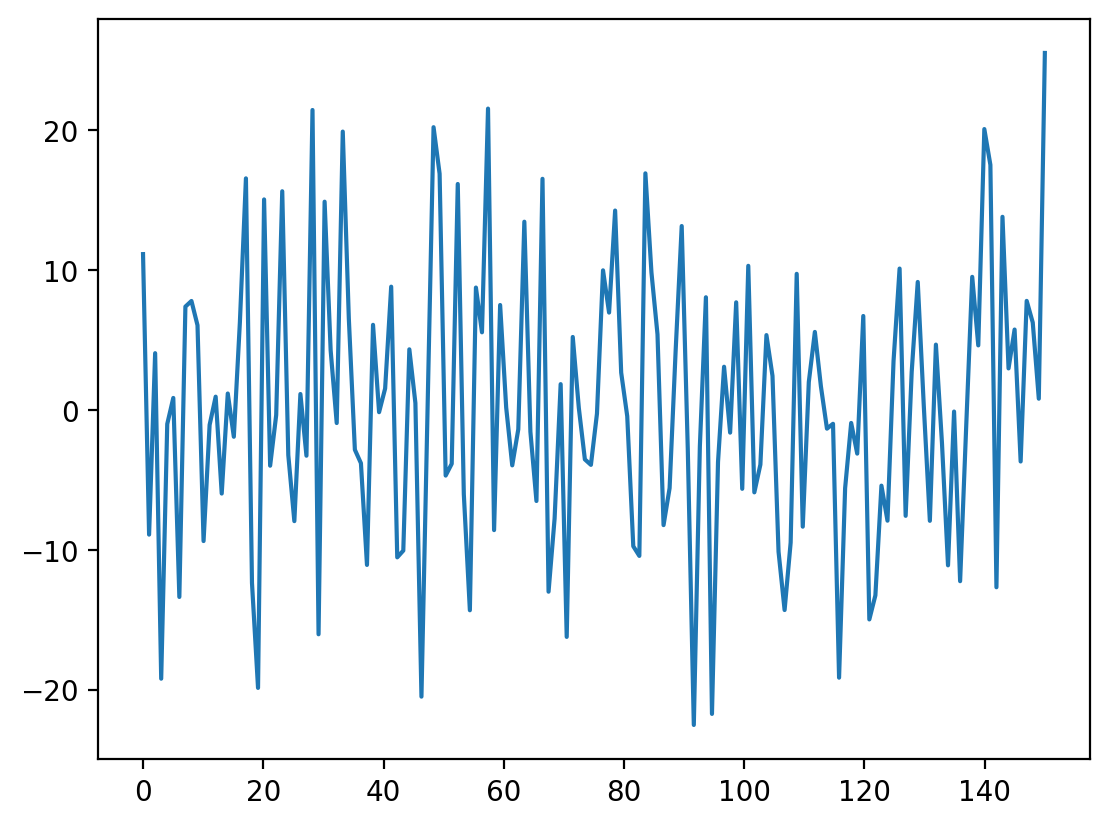

In [7]:
sample_1 = ppc_samples.stan_variable('y_pred')[1]
x = np.linspace(0,150,N)
plt.plot(x,sample_1)

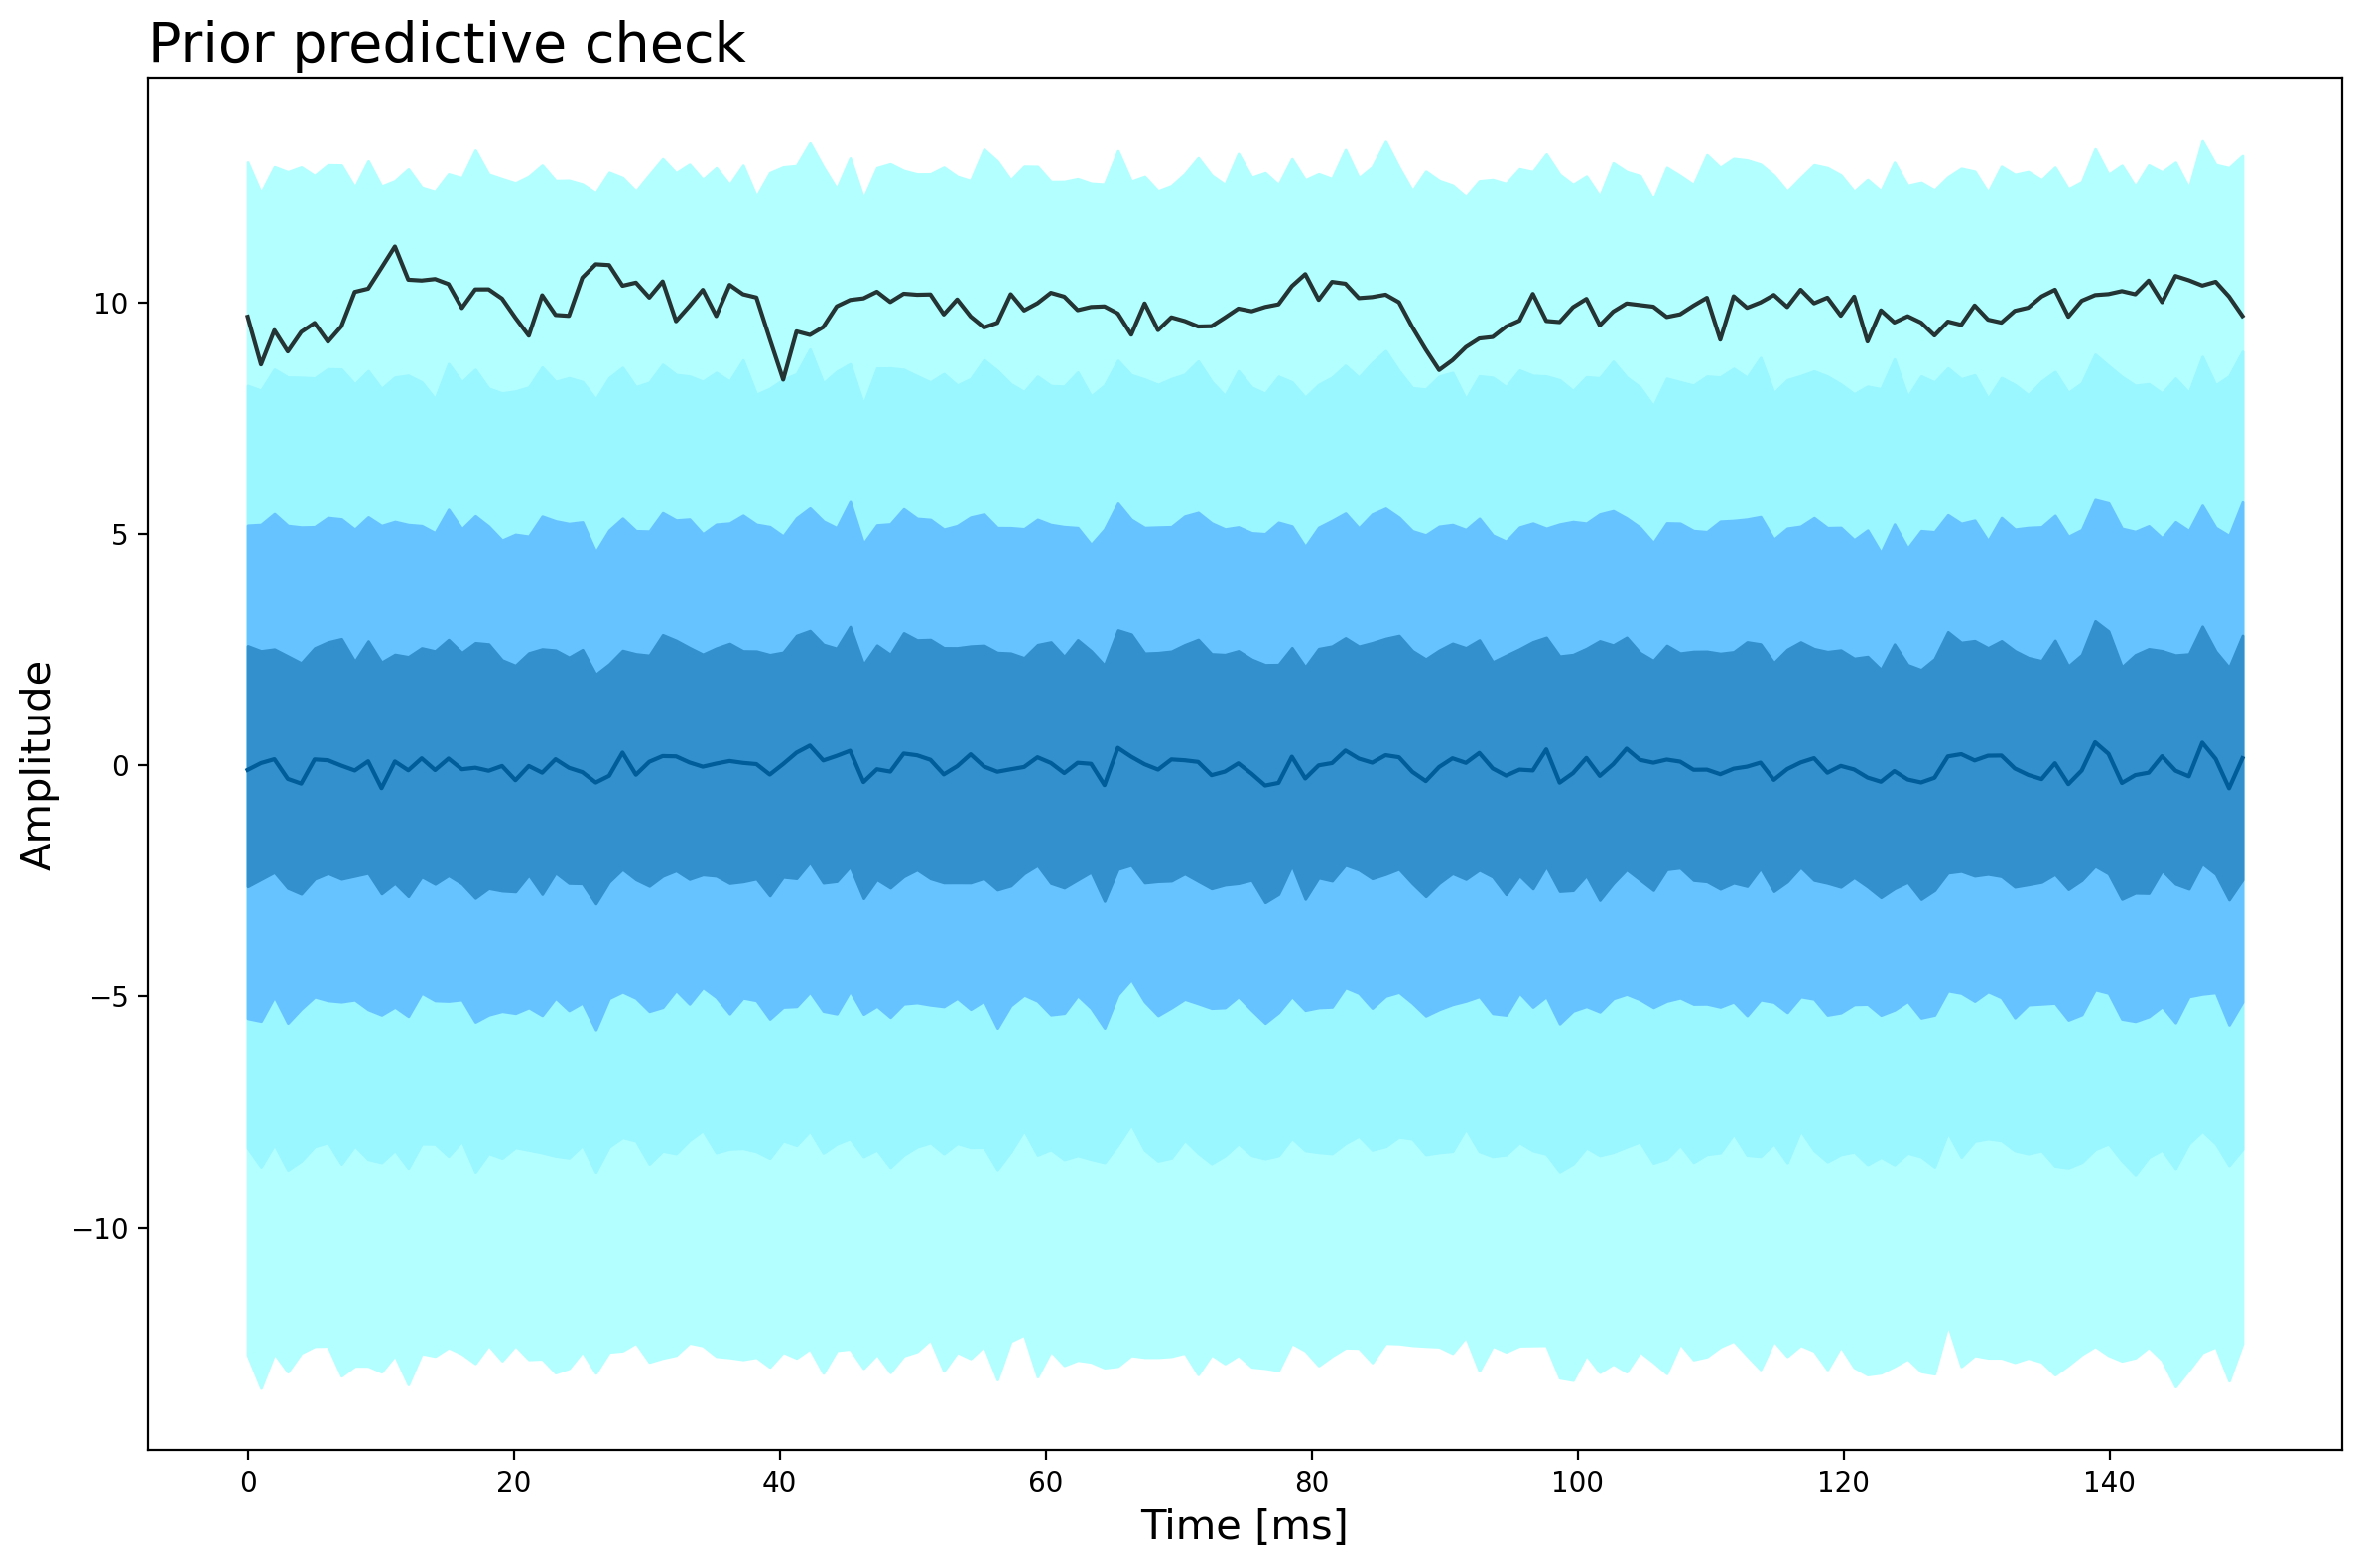

In [8]:
x = np.linspace(0,150,N)
fig = plt.figure(figsize=(12, 8), tight_layout = True)
axes = plt.subplot(1, 1 ,1)
beta_pred= ppc_samples.stan_variable('betas')[:,:]
pred = ppc_samples.stan_variable('y_pred')
axes = ribbon_plot(x,pred,axes,supress_warning=True,probs = [10, 20, 30, 40, 50, 60, 70, 80, 90])
axes.set_xlabel('Time [ms]',fontsize = 15)
axes.set_ylabel('Amplitude',fontsize = 15)
axes.set_title('Prior predictive check', loc= 'left',fontsize = 20)
axes.plot(x,acc_healthy_data[1], color = 'k',alpha=0.8)

Posterior Check model 1

As a posterior check we provide accuracy of our model, calculated as statistic of 100 independent runs and also we create generative model for each class to compare them with real signals

In [9]:
model_posterior = CmdStanModel(stan_file="stan/posterior_check.stan")
I = 5
num_knots = 15
N = 150
times = np.linspace(0,N*10,N)
knot_list = np.quantile(times,np.linspace(0,1,num_knots))
B0 = create_spline_matrix(N, times, 3, num_knots)
sampling_order = np.random.permutation([*range(len(acc[0]))])
y = acc[0][sampling_order][:I]

data_ppc = {
    "I": I,
    "N": N,
    "K": num_knots+2,
    "X": B0,
    "y": y.T
}

samples_posterior = model_posterior.sample(data=data_ppc)


18:40:14 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:40:15 - cmdstanpy - INFO - CmdStan done processing.


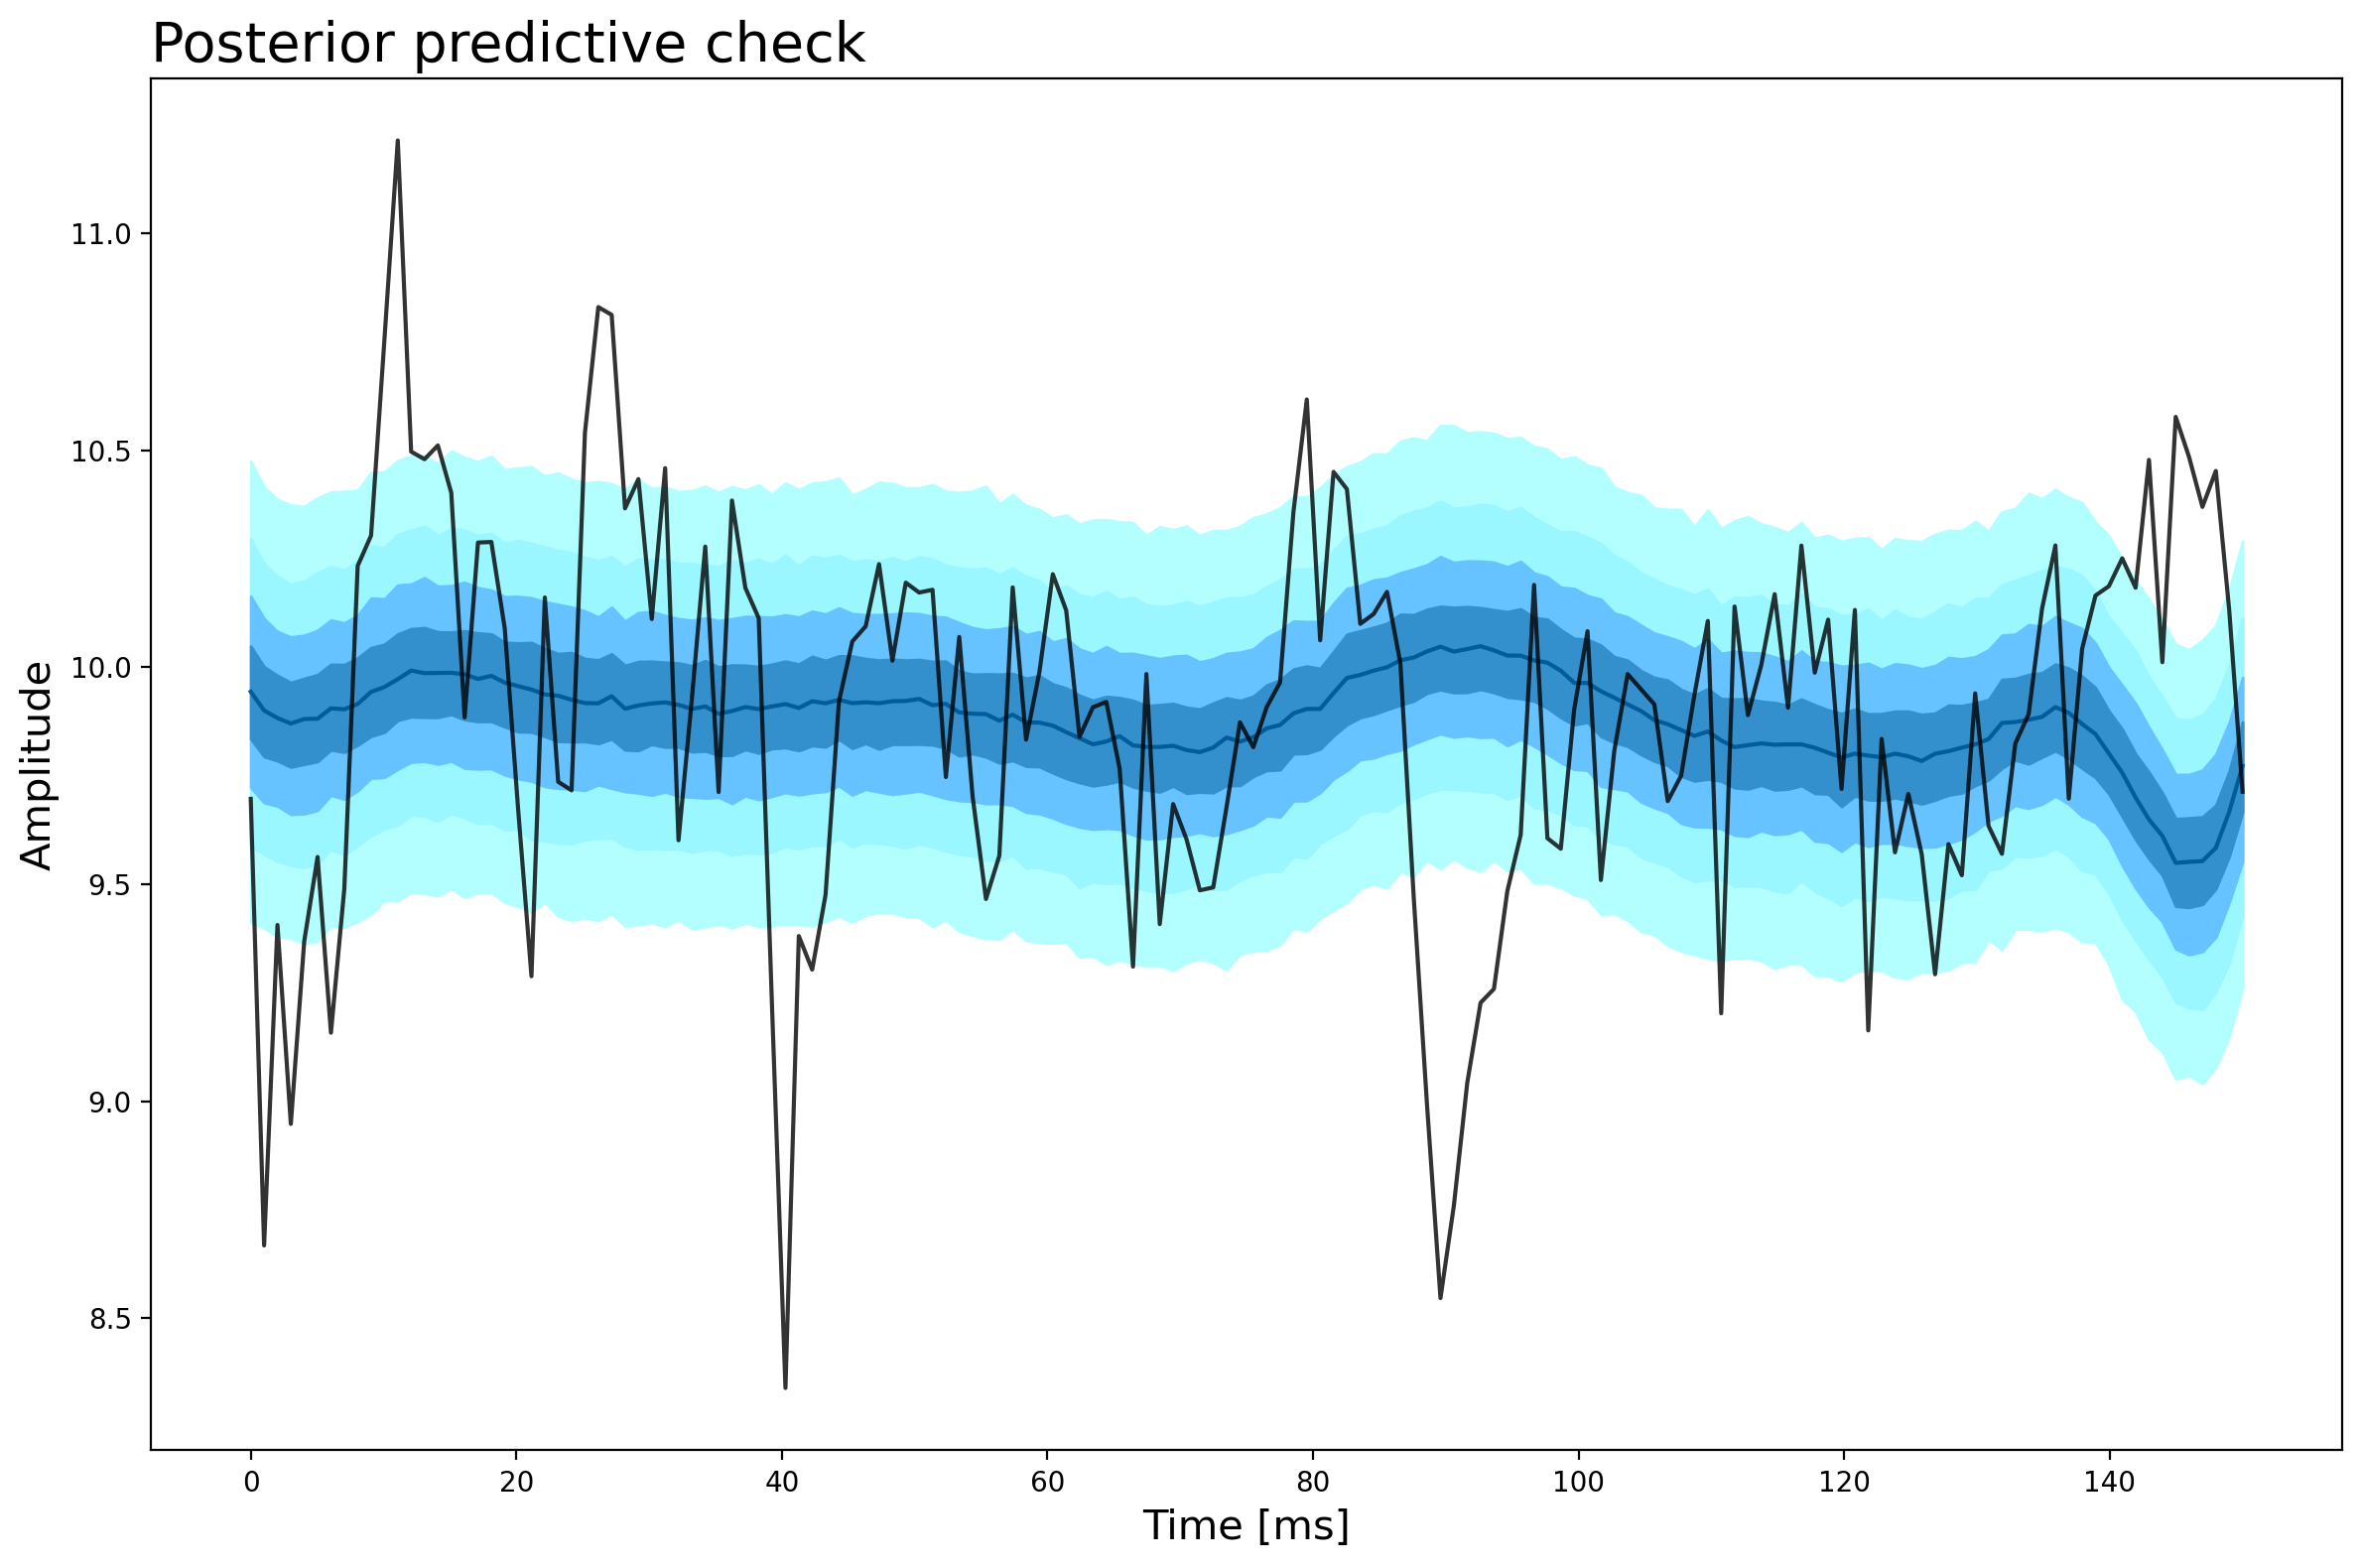

In [10]:
x = np.linspace(0,150,N)
fig = plt.figure(figsize=(12, 8), tight_layout = True)
axes = plt.subplot(1, 1 ,1)
y_pred= samples_posterior.stan_variable('y_pred')[:,:]
# pred = beta_pred@B0.T
axes = ribbon_plot(x,y_pred,axes,supress_warning=True,probs = [10, 20, 30, 40, 50, 60, 70, 80, 90])
axes.set_xlabel('Time [ms]',fontsize = 15)
axes.set_ylabel('Amplitude',fontsize = 15)
axes.set_title('Posterior predictive check', loc= 'left',fontsize = 20)
axes.plot(x,acc_healthy_data[1], color = 'k',alpha=0.8)

In [11]:
def prepare_data(data_array,spl_order = 3, num_knots = 30, frequencies = None, 
                 mode = 'binary', training_samples = 5,lambda0=None):
    N = len(data_array[0][0])
    spl_order = spl_order
    num_knots = num_knots
    if frequencies is None:
        times = np.linspace(0,N*10,N)
        knot_list = np.quantile(times,np.linspace(0,1,num_knots))
        B0 = create_spline_matrix(N, times, spl_order, num_knots)

    else:
        knot_list = np.quantile(frequencies,np.linspace(0,1,num_knots))
        B0 = create_spline_matrix(N, frequencies, spl_order, num_knots)

    K = num_knots+2
    if mode == 'binary':
        M = 2
        IL1 = training_samples
        IL2 = training_samples
        IL = IL1+IL2

        num_healthy = len(data_array[0])
        num_damaged = len(data_array[1])+len(data_array[2])
        data_array_damaged = np.concatenate([data_array[1], data_array[2]])
        total = num_healthy + num_damaged
        IT = total - IL

        sampling_order_1 = np.random.permutation([*range(num_healthy)])
        sampling_order_2 = np.random.permutation([*range(num_damaged)])

        y_labeled = np.concatenate(
        [np.array(data_array[0])[sampling_order_1[:IL1]],
            np.array(data_array_damaged)[sampling_order_2[:IL2]]])
        y_labeled = y_labeled.T
        labels = np.concatenate([np.ones(IL1), 2*np.ones(IL2)]).astype(int)


        y_test = np.concatenate(
            [np.array(data_array[0])[sampling_order_1[IL1:]],
                np.array(data_array_damaged)[sampling_order_2[IL2:]]
                ]
        )
        y_test = y_test.T
        y_test_labels = np.concatenate([np.ones(num_healthy-IL1), 2*np.ones(num_damaged-IL2)]).astype(int)
        if lambda0 is None:
            lambda0 = np.array([(IL1)/(IL), (IL2)/(IL)])

        IT = y_test.shape[1]

    if mode == 'all':
        M = 3
        IL1 = training_samples
        IL2 = training_samples
        IL3 = training_samples
        IL = IL1+IL2+IL3

        num_healthy = len(data_array[0])
        num_damaged = len(data_array[1])
        num_very_damaged = len(data_array[2])

        total = num_healthy + num_damaged + num_very_damaged
        IT = total - IL

        sampling_order_1 = np.random.permutation([*range(num_healthy)])
        sampling_order_2 = np.random.permutation([*range(num_damaged)])
        sampling_order_3 = np.random.permutation([*range(num_very_damaged)])

        y_labeled = np.concatenate(
        [np.array(data_array[0])[sampling_order_1[:IL1]],
            np.array(data_array[1])[sampling_order_2[:IL2]],
            np.array(data_array[2])[sampling_order_3[:IL3]],
            ])
        y_labeled = y_labeled.T
        labels = np.concatenate([np.ones(IL1), 2*np.ones(IL2), 3*np.ones(IL3)]).astype(int)


        y_test = np.concatenate(
            [np.array(data_array[0])[sampling_order_1[IL1:]],
                np.array(data_array[1])[sampling_order_2[IL2:]],
                np.array(data_array[2])[sampling_order_3[IL3:]]
                ]
        )
        y_test = y_test.T
        y_test_labels = np.concatenate([np.ones(num_healthy-IL1), 2*np.ones(num_damaged-IL2),3*np.ones(num_very_damaged-IL3)]).astype(int)
        if lambda0 is None:
            lambda0 = np.array([(IL1)/(IL), (IL2)/(IL), (IL3)/(IL)])

        IT = y_test.shape[1]

    data_out = {
    "N": N,
    "IL": IL,
    "K": K,
    "M": M,
    "x": B0,
    "labels": labels,
    "y_labeled": y_labeled,
    "lambda0": lambda0,
    "IT": IT,
    "y_test": y_test,
    }

    return data_out, y_test_labels, IT, IL, total, B0, knot_list
    

def get_results(model, data, labels, IT, IL, total, mode = 'binary', seed = None):
    if not seed:
        seed = np.random.randint(0,100000)
    if mode == 'binary':
        result = model.sample(data=data, seed=seed)
        probs_from_arviz = az.summary(
        result, "log_probabilities", kind='stats', round_to=5)
        probs_from_arviz_p = az.summary(
            result, "probabilities", kind='stats', round_to=5)
            
        indices_cat1 = labels == 1
        indices_cat2 = labels == 2

        cat1 = probs_from_arviz.iloc[:IT, :].iloc[indices_cat1, :]
        cat2 = probs_from_arviz.iloc[IT:2*IT, :].iloc[indices_cat2, :]

        cat1p = probs_from_arviz_p.iloc[:IT, :].iloc[indices_cat1, :]
        cat2p = probs_from_arviz_p.iloc[IT:2*IT, :].iloc[indices_cat2, :]


        a = sum((cat1["mean"].values) < np.log(0.5))
        b = sum((cat2["mean"].values) < np.log(0.5))

        hit_rate = 1 - (a+b)/(total-IL)
        print('hit rate = ',hit_rate)
    if mode == 'all':
        result = model.sample(data=data, seed=seed)
        probs_from_arviz = az.summary(
        result, "log_probabilities", kind='stats', round_to=5)
        probs_from_arviz_p = az.summary(
            result, "probabilities", kind='stats', round_to=5)
            
        indices_cat1 = labels == 1
        indices_cat2 = labels == 2
        indices_cat3 = labels == 2

        cat1 = probs_from_arviz.iloc[:IT, :].iloc[indices_cat1, :]
        cat2 = probs_from_arviz.iloc[IT:2*IT, :].iloc[indices_cat2, :]
        cat3 = probs_from_arviz.iloc[2*IT:3*IT, :].iloc[indices_cat3, :]

        cat1p = probs_from_arviz_p.iloc[:IT, :].iloc[indices_cat1, :]
        cat2p = probs_from_arviz_p.iloc[IT:2*IT, :].iloc[indices_cat2, :]
        cat3p = probs_from_arviz_p.iloc[2*IT:3*IT, :].iloc[indices_cat3, :]


        a = sum((cat1["mean"].values) < np.log(0.5))
        b = sum((cat2["mean"].values) < np.log(0.5))
        c = sum((cat3["mean"].values) < np.log(0.5))

        hit_rate = 1 - (a+b+c)/(total-IL)
        print('hit rate = ',hit_rate)
    return hit_rate
        




In [12]:
num_knots = 25
data, labels, IT, IL, total,B0,knot_list = prepare_data(acc,frequencies=None,training_samples=5, 
                                                        num_knots=num_knots, mode = 'binary')
model = CmdStanModel(stan_file='stan/mix.stan')
seed = 26042024
get_results(model=model,data=data,seed=seed,labels=labels,IT=IT,IL=IL,total=total,mode='binary')

18:40:15 - cmdstanpy - INFO - compiling stan file /Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan to exe file /Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix
18:40:25 - cmdstanpy - INFO - compiled model executable: /Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix
18:40:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:40:29 - cmdstanpy - INFO - CmdStan done processing.



hit rate =  0.9285714285714286


0.9285714285714286

### Diffrences between models
Three binary models for detecting drone propeller damage have been developed. The models differ primarily in terms of input data, which can be distinguished as follows:

    accelerometer with data aggregation in the time domain,
    gyroscope without data aggregation in the frequency domain,
    gyroscope with data aggregation in the frequency domain.

These models were developed due to the possibility of their direct application in unmanned aerial vehicles. The model using an accelerometer will require less computational power during integration, due to the limited number of operations performed. Meanwhile, the model based on a gyroscope must process input data after a Fourier transform, which increases computational complexity.

In [13]:
knots = [5,10,15,20,25]
frequencies = gyro_damaged['Frequencies']
num_iters = 100
# accelerometer with data aggregation in the time domain
result_dict_acc = {}
for num_knots in knots:
    res = []
    for i in range(num_iters):
        data, labels, IT, IL, total ,B0, knot_list = prepare_data(acc, frequencies=None, training_samples=5, num_knots=num_knots, mode = 'binary')
        res.append(get_results(model=model, data=data, labels=labels, IT=IT,IL=IL, total=total, mode='binary'))
    result_dict_acc[f'Spline {num_knots}'] = np.mean(res)
    pd_res = pd.DataFrame(result_dict_acc,index=[0])
    pd_res.to_csv('results/agg_results.csv')

model = CmdStanModel(stan_file='stan/mix.stan')

# gyroscope without data aggregation in the frequency domain
result_dict_gyro = {}
for num_knots in knots:
    res = []
    for i in range(num_iters):
        data, labels, IT, IL, total, B0, knot_list = prepare_data(gyro, frequencies=frequencies, training_samples=5, num_knots=num_knots, mode = 'binary')
        res.append(get_results(model=model, data=data, labels=labels, IT=IT, IL=IL, total=total, mode='binary'))
    result_dict_gyro[f'Spline {num_knots}'] = np.mean(res)
    pd_res = pd.DataFrame(result_dict_gyro,index=[0])
    pd_res.to_csv('results/gyro_results.csv')

# gyroscope with data aggregation in the frequency domain
result_dict_gyro_agg = {}
for num_knots in knots:
    res = []
    for i in range(num_iters):
        data, labels, IT, IL, total, B0, knot_list = prepare_data(gyro_agg, frequencies=frequencies, training_samples=5, num_knots=num_knots, mode = 'binary')
        res.append(get_results(model=model, data=data, labels=labels, IT=IT, IL=IL, total=total, mode='binary'))
    result_dict_gyro_agg[f'Spline {num_knots}'] = np.mean(res)
    pd_res = pd.DataFrame(result_dict_gyro_agg,index=[0])
    pd_res.to_csv('results/gyro_agg_results.csv')

18:40:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:40:32 - cmdstanpy - INFO - CmdStan done processing.


18:40:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:40:35 - cmdstanpy - INFO - CmdStan done processing.


18:40:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:40:37 - cmdstanpy - INFO - CmdStan done processing.
18:40:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

18:40:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:40:40 - cmdstanpy - INFO - CmdStan done processing.


18:40:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:40:43 - cmdstanpy - INFO - CmdStan done processing.


18:40:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:40:46 - cmdstanpy - INFO - CmdStan done processing.


18:40:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:40:49 - cmdstanpy - INFO - CmdStan done processing.


18:40:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:40:52 - cmdstanpy - INFO - CmdStan done processing.


18:40:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:40:55 - cmdstanpy - INFO - CmdStan done processing.


18:40:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:40:57 - cmdstanpy - INFO - CmdStan done processing.
18:40:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:40:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:41:00 - cmdstanpy - INFO - CmdStan done processing.


18:41:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:41:03 - cmdstanpy - INFO - CmdStan done processing.
18:41:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:41:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:41:06 - cmdstanpy - INFO - CmdStan done processing.


18:41:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:41:09 - cmdstanpy - INFO - CmdStan done processing.


18:41:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:41:12 - cmdstanpy - INFO - CmdStan done processing.
18:41:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:41:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:41:14 - cmdstanpy - INFO - CmdStan done processing.


18:41:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:41:17 - cmdstanpy - INFO - CmdStan done processing.


18:41:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:41:20 - cmdstanpy - INFO - CmdStan done processing.


18:41:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  1.0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:41:23 - cmdstanpy - INFO - CmdStan done processing.
18:41:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:41:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:41:26 - cmdstanpy - INFO - CmdStan done processing.


18:41:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:41:29 - cmdstanpy - INFO - CmdStan done processing.


18:41:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:41:32 - cmdstanpy - INFO - CmdStan done processing.


18:41:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:41:34 - cmdstanpy - INFO - CmdStan done processing.
18:41:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:41:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9821428571428571


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:41:37 - cmdstanpy - INFO - CmdStan done processing.


18:41:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:41:40 - cmdstanpy - INFO - CmdStan done processing.


18:41:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:41:43 - cmdstanpy - INFO - CmdStan done processing.


18:41:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:41:46 - cmdstanpy - INFO - CmdStan done processing.


18:41:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:41:48 - cmdstanpy - INFO - CmdStan done processing.


18:41:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:41:51 - cmdstanpy - INFO - CmdStan done processing.


18:41:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:41:54 - cmdstanpy - INFO - CmdStan done processing.


18:41:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:41:57 - cmdstanpy - INFO - CmdStan done processing.


18:41:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:42:00 - cmdstanpy - INFO - CmdStan done processing.


18:42:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:42:03 - cmdstanpy - INFO - CmdStan done processing.


18:42:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:42:05 - cmdstanpy - INFO - CmdStan done processing.


18:42:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:42:08 - cmdstanpy - INFO - CmdStan done processing.


18:42:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:42:11 - cmdstanpy - INFO - CmdStan done processing.


18:42:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:42:14 - cmdstanpy - INFO - CmdStan done processing.


18:42:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:42:17 - cmdstanpy - INFO - CmdStan done processing.


18:42:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:42:20 - cmdstanpy - INFO - CmdStan done processing.
18:42:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:42:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:42:23 - cmdstanpy - INFO - CmdStan done processing.


18:42:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:42:26 - cmdstanpy - INFO - CmdStan done processing.
18:42:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:42:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:42:29 - cmdstanpy - INFO - CmdStan done processing.
18:42:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:42:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:42:32 - cmdstanpy - INFO - CmdStan done processing.


18:42:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:42:35 - cmdstanpy - INFO - CmdStan done processing.


18:42:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9821428571428571


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:42:38 - cmdstanpy - INFO - CmdStan done processing.


18:42:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:42:41 - cmdstanpy - INFO - CmdStan done processing.


18:42:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:42:44 - cmdstanpy - INFO - CmdStan done processing.


18:42:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:42:47 - cmdstanpy - INFO - CmdStan done processing.


18:42:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:42:50 - cmdstanpy - INFO - CmdStan done processing.


18:42:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:42:53 - cmdstanpy - INFO - CmdStan done processing.


18:42:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:42:55 - cmdstanpy - INFO - CmdStan done processing.


18:42:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:42:58 - cmdstanpy - INFO - CmdStan done processing.


18:42:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:43:01 - cmdstanpy - INFO - CmdStan done processing.


18:43:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:43:04 - cmdstanpy - INFO - CmdStan done processing.


18:43:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:43:07 - cmdstanpy - INFO - CmdStan done processing.


18:43:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:43:09 - cmdstanpy - INFO - CmdStan done processing.
18:43:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:43:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:43:12 - cmdstanpy - INFO - CmdStan done processing.


18:43:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:43:15 - cmdstanpy - INFO - CmdStan done processing.


18:43:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:43:18 - cmdstanpy - INFO - CmdStan done processing.


18:43:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:43:21 - cmdstanpy - INFO - CmdStan done processing.


18:43:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9821428571428571


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:43:24 - cmdstanpy - INFO - CmdStan done processing.


18:43:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:43:27 - cmdstanpy - INFO - CmdStan done processing.


18:43:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:43:30 - cmdstanpy - INFO - CmdStan done processing.


18:43:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:43:33 - cmdstanpy - INFO - CmdStan done processing.


18:43:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:43:36 - cmdstanpy - INFO - CmdStan done processing.


18:43:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:43:39 - cmdstanpy - INFO - CmdStan done processing.


18:43:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:43:42 - cmdstanpy - INFO - CmdStan done processing.
18:43:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

18:43:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:43:44 - cmdstanpy - INFO - CmdStan done processing.


18:43:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:43:47 - cmdstanpy - INFO - CmdStan done processing.
18:43:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:43:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:43:50 - cmdstanpy - INFO - CmdStan done processing.


18:43:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:43:53 - cmdstanpy - INFO - CmdStan done processing.


18:43:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:43:56 - cmdstanpy - INFO - CmdStan done processing.


18:43:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:43:59 - cmdstanpy - INFO - CmdStan done processing.
18:43:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:43:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:44:02 - cmdstanpy - INFO - CmdStan done processing.


18:44:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:44:05 - cmdstanpy - INFO - CmdStan done processing.


18:44:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:44:08 - cmdstanpy - INFO - CmdStan done processing.


18:44:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:44:11 - cmdstanpy - INFO - CmdStan done processing.


18:44:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:44:14 - cmdstanpy - INFO - CmdStan done processing.


18:44:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:44:17 - cmdstanpy - INFO - CmdStan done processing.


18:44:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:44:20 - cmdstanpy - INFO - CmdStan done processing.


18:44:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:44:23 - cmdstanpy - INFO - CmdStan done processing.


18:44:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9821428571428571


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:44:25 - cmdstanpy - INFO - CmdStan done processing.


18:44:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:44:28 - cmdstanpy - INFO - CmdStan done processing.


18:44:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  1.0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:44:31 - cmdstanpy - INFO - CmdStan done processing.


18:44:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9821428571428571


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:44:34 - cmdstanpy - INFO - CmdStan done processing.


18:44:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:44:37 - cmdstanpy - INFO - CmdStan done processing.


18:44:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:44:40 - cmdstanpy - INFO - CmdStan done processing.


18:44:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:44:43 - cmdstanpy - INFO - CmdStan done processing.


18:44:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:44:46 - cmdstanpy - INFO - CmdStan done processing.


18:44:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:44:49 - cmdstanpy - INFO - CmdStan done processing.
18:44:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:44:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:44:52 - cmdstanpy - INFO - CmdStan done processing.


18:44:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:44:55 - cmdstanpy - INFO - CmdStan done processing.
18:44:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:44:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:44:58 - cmdstanpy - INFO - CmdStan done processing.


18:44:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:45:01 - cmdstanpy - INFO - CmdStan done processing.


18:45:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:45:04 - cmdstanpy - INFO - CmdStan done processing.


18:45:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:45:07 - cmdstanpy - INFO - CmdStan done processing.


18:45:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:45:10 - cmdstanpy - INFO - CmdStan done processing.


18:45:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:45:13 - cmdstanpy - INFO - CmdStan done processing.
18:45:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:45:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:45:15 - cmdstanpy - INFO - CmdStan done processing.


18:45:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:45:18 - cmdstanpy - INFO - CmdStan done processing.


18:45:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:45:21 - cmdstanpy - INFO - CmdStan done processing.


18:45:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:45:25 - cmdstanpy - INFO - CmdStan done processing.


18:45:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:45:28 - cmdstanpy - INFO - CmdStan done processing.
18:45:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:45:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:45:31 - cmdstanpy - INFO - CmdStan done processing.


18:45:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:45:34 - cmdstanpy - INFO - CmdStan done processing.


18:45:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:45:37 - cmdstanpy - INFO - CmdStan done processing.


18:45:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:45:40 - cmdstanpy - INFO - CmdStan done processing.


18:45:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:45:44 - cmdstanpy - INFO - CmdStan done processing.
18:45:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

18:45:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:45:47 - cmdstanpy - INFO - CmdStan done processing.


18:45:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:45:51 - cmdstanpy - INFO - CmdStan done processing.


18:45:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:45:54 - cmdstanpy - INFO - CmdStan done processing.


18:45:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:45:57 - cmdstanpy - INFO - CmdStan done processing.


18:45:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:46:01 - cmdstanpy - INFO - CmdStan done processing.


18:46:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:46:04 - cmdstanpy - INFO - CmdStan done processing.


18:46:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:46:07 - cmdstanpy - INFO - CmdStan done processing.


18:46:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:46:11 - cmdstanpy - INFO - CmdStan done processing.
18:46:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:46:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:46:14 - cmdstanpy - INFO - CmdStan done processing.


18:46:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:46:17 - cmdstanpy - INFO - CmdStan done processing.


18:46:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:46:21 - cmdstanpy - INFO - CmdStan done processing.


18:46:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:46:24 - cmdstanpy - INFO - CmdStan done processing.


18:46:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:46:28 - cmdstanpy - INFO - CmdStan done processing.
18:46:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:46:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:46:31 - cmdstanpy - INFO - CmdStan done processing.


18:46:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:46:34 - cmdstanpy - INFO - CmdStan done processing.


18:46:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:46:38 - cmdstanpy - INFO - CmdStan done processing.
18:46:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:46:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:46:41 - cmdstanpy - INFO - CmdStan done processing.


18:46:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:46:45 - cmdstanpy - INFO - CmdStan done processing.


18:46:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:46:48 - cmdstanpy - INFO - CmdStan done processing.


18:46:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:46:52 - cmdstanpy - INFO - CmdStan done processing.


18:46:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:46:55 - cmdstanpy - INFO - CmdStan done processing.
18:46:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:46:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:46:59 - cmdstanpy - INFO - CmdStan done processing.


18:46:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:47:02 - cmdstanpy - INFO - CmdStan done processing.


18:47:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:47:06 - cmdstanpy - INFO - CmdStan done processing.
18:47:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:47:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:47:09 - cmdstanpy - INFO - CmdStan done processing.


18:47:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:47:13 - cmdstanpy - INFO - CmdStan done processing.


18:47:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:47:16 - cmdstanpy - INFO - CmdStan done processing.


18:47:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:47:20 - cmdstanpy - INFO - CmdStan done processing.


18:47:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:47:23 - cmdstanpy - INFO - CmdStan done processing.
18:47:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:47:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:47:27 - cmdstanpy - INFO - CmdStan done processing.


18:47:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:47:30 - cmdstanpy - INFO - CmdStan done processing.


18:47:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:47:34 - cmdstanpy - INFO - CmdStan done processing.


18:47:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:47:37 - cmdstanpy - INFO - CmdStan done processing.


18:47:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:47:41 - cmdstanpy - INFO - CmdStan done processing.


18:47:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:47:44 - cmdstanpy - INFO - CmdStan done processing.


18:47:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:47:48 - cmdstanpy - INFO - CmdStan done processing.


18:47:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:47:52 - cmdstanpy - INFO - CmdStan done processing.


18:47:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:47:55 - cmdstanpy - INFO - CmdStan done processing.


18:47:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:47:59 - cmdstanpy - INFO - CmdStan done processing.
18:47:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:47:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:48:02 - cmdstanpy - INFO - CmdStan done processing.
18:48:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyn

18:48:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:48:06 - cmdstanpy - INFO - CmdStan done processing.


18:48:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:48:09 - cmdstanpy - INFO - CmdStan done processing.


18:48:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:48:13 - cmdstanpy - INFO - CmdStan done processing.


18:48:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:48:16 - cmdstanpy - INFO - CmdStan done processing.


18:48:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:48:19 - cmdstanpy - INFO - CmdStan done processing.


18:48:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:48:23 - cmdstanpy - INFO - CmdStan done processing.


18:48:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:48:27 - cmdstanpy - INFO - CmdStan done processing.
18:48:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:48:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:48:30 - cmdstanpy - INFO - CmdStan done processing.
18:48:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:48:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  1.0


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:48:33 - cmdstanpy - INFO - CmdStan done processing.


18:48:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:48:37 - cmdstanpy - INFO - CmdStan done processing.
18:48:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:48:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:48:41 - cmdstanpy - INFO - CmdStan done processing.


18:48:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:48:44 - cmdstanpy - INFO - CmdStan done processing.


18:48:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:48:48 - cmdstanpy - INFO - CmdStan done processing.
18:48:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:48:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:48:51 - cmdstanpy - INFO - CmdStan done processing.


18:48:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:48:55 - cmdstanpy - INFO - CmdStan done processing.


18:48:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:48:58 - cmdstanpy - INFO - CmdStan done processing.


18:48:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:49:02 - cmdstanpy - INFO - CmdStan done processing.


18:49:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:49:05 - cmdstanpy - INFO - CmdStan done processing.


18:49:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:49:09 - cmdstanpy - INFO - CmdStan done processing.


18:49:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:49:12 - cmdstanpy - INFO - CmdStan done processing.


18:49:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:49:16 - cmdstanpy - INFO - CmdStan done processing.


18:49:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:49:19 - cmdstanpy - INFO - CmdStan done processing.


18:49:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:49:23 - cmdstanpy - INFO - CmdStan done processing.


18:49:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:49:27 - cmdstanpy - INFO - CmdStan done processing.


18:49:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:49:30 - cmdstanpy - INFO - CmdStan done processing.


18:49:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:49:34 - cmdstanpy - INFO - CmdStan done processing.


18:49:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:49:38 - cmdstanpy - INFO - CmdStan done processing.


18:49:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:49:41 - cmdstanpy - INFO - CmdStan done processing.


18:49:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:49:45 - cmdstanpy - INFO - CmdStan done processing.
18:49:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:49:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:49:48 - cmdstanpy - INFO - CmdStan done processing.


18:49:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:49:52 - cmdstanpy - INFO - CmdStan done processing.
18:49:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:49:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:49:55 - cmdstanpy - INFO - CmdStan done processing.


18:49:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:49:59 - cmdstanpy - INFO - CmdStan done processing.
18:49:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:49:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:50:02 - cmdstanpy - INFO - CmdStan done processing.


18:50:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:50:06 - cmdstanpy - INFO - CmdStan done processing.


18:50:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:50:09 - cmdstanpy - INFO - CmdStan done processing.


18:50:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:50:13 - cmdstanpy - INFO - CmdStan done processing.
18:50:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:50:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:50:16 - cmdstanpy - INFO - CmdStan done processing.


18:50:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:50:20 - cmdstanpy - INFO - CmdStan done processing.


18:50:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:50:23 - cmdstanpy - INFO - CmdStan done processing.


18:50:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:50:27 - cmdstanpy - INFO - CmdStan done processing.


18:50:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:50:30 - cmdstanpy - INFO - CmdStan done processing.


18:50:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:50:34 - cmdstanpy - INFO - CmdStan done processing.


18:50:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:50:37 - cmdstanpy - INFO - CmdStan done processing.


18:50:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:50:41 - cmdstanpy - INFO - CmdStan done processing.


18:50:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:50:44 - cmdstanpy - INFO - CmdStan done processing.


18:50:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:50:48 - cmdstanpy - INFO - CmdStan done processing.


18:50:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:50:52 - cmdstanpy - INFO - CmdStan done processing.


18:50:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:50:56 - cmdstanpy - INFO - CmdStan done processing.


18:50:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:50:59 - cmdstanpy - INFO - CmdStan done processing.


18:50:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9821428571428571


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:51:03 - cmdstanpy - INFO - CmdStan done processing.


18:51:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:51:06 - cmdstanpy - INFO - CmdStan done processing.
18:51:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:51:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:51:10 - cmdstanpy - INFO - CmdStan done processing.


18:51:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:51:14 - cmdstanpy - INFO - CmdStan done processing.


18:51:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:51:18 - cmdstanpy - INFO - CmdStan done processing.


18:51:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:51:22 - cmdstanpy - INFO - CmdStan done processing.
18:51:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:51:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:51:26 - cmdstanpy - INFO - CmdStan done processing.
18:51:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:51:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:51:30 - cmdstanpy - INFO - CmdStan done processing.


18:51:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:51:33 - cmdstanpy - INFO - CmdStan done processing.


18:51:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:51:37 - cmdstanpy - INFO - CmdStan done processing.


18:51:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9821428571428571


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:51:41 - cmdstanpy - INFO - CmdStan done processing.


18:51:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:51:45 - cmdstanpy - INFO - CmdStan done processing.


18:51:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:51:49 - cmdstanpy - INFO - CmdStan done processing.


18:51:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:51:52 - cmdstanpy - INFO - CmdStan done processing.


18:51:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:51:56 - cmdstanpy - INFO - CmdStan done processing.
18:51:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:51:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:52:00 - cmdstanpy - INFO - CmdStan done processing.


18:52:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:52:04 - cmdstanpy - INFO - CmdStan done processing.


18:52:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:52:08 - cmdstanpy - INFO - CmdStan done processing.


18:52:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:52:11 - cmdstanpy - INFO - CmdStan done processing.


18:52:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:52:15 - cmdstanpy - INFO - CmdStan done processing.


18:52:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:52:19 - cmdstanpy - INFO - CmdStan done processing.
18:52:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:52:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:52:23 - cmdstanpy - INFO - CmdStan done processing.


18:52:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:52:27 - cmdstanpy - INFO - CmdStan done processing.


18:52:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:52:31 - cmdstanpy - INFO - CmdStan done processing.


18:52:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:52:35 - cmdstanpy - INFO - CmdStan done processing.


18:52:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:52:39 - cmdstanpy - INFO - CmdStan done processing.
18:52:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:52:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:52:43 - cmdstanpy - INFO - CmdStan done processing.


18:52:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:52:47 - cmdstanpy - INFO - CmdStan done processing.


18:52:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:52:51 - cmdstanpy - INFO - CmdStan done processing.


18:52:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:52:55 - cmdstanpy - INFO - CmdStan done processing.
18:52:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:52:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9821428571428571


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:52:59 - cmdstanpy - INFO - CmdStan done processing.
18:52:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:53:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:53:03 - cmdstanpy - INFO - CmdStan done processing.


18:53:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:53:07 - cmdstanpy - INFO - CmdStan done processing.


18:53:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:53:11 - cmdstanpy - INFO - CmdStan done processing.
18:53:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:53:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:53:15 - cmdstanpy - INFO - CmdStan done processing.


18:53:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:53:20 - cmdstanpy - INFO - CmdStan done processing.


18:53:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:53:24 - cmdstanpy - INFO - CmdStan done processing.
18:53:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:53:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:53:28 - cmdstanpy - INFO - CmdStan done processing.
18:53:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:53:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:53:31 - cmdstanpy - INFO - CmdStan done processing.
18:53:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:53:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:53:35 - cmdstanpy - INFO - CmdStan done processing.


18:53:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:53:40 - cmdstanpy - INFO - CmdStan done processing.


18:53:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:53:44 - cmdstanpy - INFO - CmdStan done processing.


18:53:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:53:48 - cmdstanpy - INFO - CmdStan done processing.


18:53:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:53:52 - cmdstanpy - INFO - CmdStan done processing.


18:53:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:53:55 - cmdstanpy - INFO - CmdStan done processing.


18:53:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:53:59 - cmdstanpy - INFO - CmdStan done processing.


18:54:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:54:03 - cmdstanpy - INFO - CmdStan done processing.
18:54:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:54:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:54:07 - cmdstanpy - INFO - CmdStan done processing.


18:54:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:54:11 - cmdstanpy - INFO - CmdStan done processing.


18:54:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:54:15 - cmdstanpy - INFO - CmdStan done processing.


18:54:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:54:19 - cmdstanpy - INFO - CmdStan done processing.


18:54:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:54:23 - cmdstanpy - INFO - CmdStan done processing.


18:54:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:54:27 - cmdstanpy - INFO - CmdStan done processing.


18:54:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:54:31 - cmdstanpy - INFO - CmdStan done processing.


18:54:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9821428571428571


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:54:34 - cmdstanpy - INFO - CmdStan done processing.


18:54:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:54:38 - cmdstanpy - INFO - CmdStan done processing.


18:54:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:54:42 - cmdstanpy - INFO - CmdStan done processing.
18:54:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:54:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:54:46 - cmdstanpy - INFO - CmdStan done processing.


18:54:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:54:50 - cmdstanpy - INFO - CmdStan done processing.


18:54:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:54:54 - cmdstanpy - INFO - CmdStan done processing.


18:54:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:54:58 - cmdstanpy - INFO - CmdStan done processing.


18:54:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:55:02 - cmdstanpy - INFO - CmdStan done processing.


18:55:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:55:06 - cmdstanpy - INFO - CmdStan done processing.


18:55:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:55:10 - cmdstanpy - INFO - CmdStan done processing.


18:55:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:55:14 - cmdstanpy - INFO - CmdStan done processing.


18:55:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:55:18 - cmdstanpy - INFO - CmdStan done processing.


18:55:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:55:22 - cmdstanpy - INFO - CmdStan done processing.


18:55:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:55:27 - cmdstanpy - INFO - CmdStan done processing.


18:55:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:55:31 - cmdstanpy - INFO - CmdStan done processing.


18:55:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:55:35 - cmdstanpy - INFO - CmdStan done processing.


18:55:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:55:39 - cmdstanpy - INFO - CmdStan done processing.


18:55:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:55:43 - cmdstanpy - INFO - CmdStan done processing.


18:55:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:55:47 - cmdstanpy - INFO - CmdStan done processing.


18:55:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:55:51 - cmdstanpy - INFO - CmdStan done processing.


18:55:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:55:55 - cmdstanpy - INFO - CmdStan done processing.


18:55:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:55:59 - cmdstanpy - INFO - CmdStan done processing.


18:55:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:56:03 - cmdstanpy - INFO - CmdStan done processing.


18:56:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:56:07 - cmdstanpy - INFO - CmdStan done processing.


18:56:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:56:11 - cmdstanpy - INFO - CmdStan done processing.


18:56:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:56:15 - cmdstanpy - INFO - CmdStan done processing.
18:56:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:56:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:56:19 - cmdstanpy - INFO - CmdStan done processing.


18:56:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9821428571428571


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:56:23 - cmdstanpy - INFO - CmdStan done processing.


18:56:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:56:27 - cmdstanpy - INFO - CmdStan done processing.


18:56:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:56:31 - cmdstanpy - INFO - CmdStan done processing.
18:56:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:56:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:56:35 - cmdstanpy - INFO - CmdStan done processing.


18:56:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:56:39 - cmdstanpy - INFO - CmdStan done processing.


18:56:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:56:43 - cmdstanpy - INFO - CmdStan done processing.


18:56:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:56:46 - cmdstanpy - INFO - CmdStan done processing.
18:56:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:56:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:56:50 - cmdstanpy - INFO - CmdStan done processing.


18:56:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:56:54 - cmdstanpy - INFO - CmdStan done processing.


18:56:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:56:58 - cmdstanpy - INFO - CmdStan done processing.


18:56:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:57:02 - cmdstanpy - INFO - CmdStan done processing.


18:57:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:57:06 - cmdstanpy - INFO - CmdStan done processing.


18:57:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:57:10 - cmdstanpy - INFO - CmdStan done processing.


18:57:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:57:14 - cmdstanpy - INFO - CmdStan done processing.


18:57:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:57:18 - cmdstanpy - INFO - CmdStan done processing.
18:57:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:57:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:57:22 - cmdstanpy - INFO - CmdStan done processing.


18:57:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:57:26 - cmdstanpy - INFO - CmdStan done processing.


18:57:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:57:30 - cmdstanpy - INFO - CmdStan done processing.
18:57:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:57:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:57:33 - cmdstanpy - INFO - CmdStan done processing.


18:57:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:57:37 - cmdstanpy - INFO - CmdStan done processing.


18:57:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:57:41 - cmdstanpy - INFO - CmdStan done processing.


18:57:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:57:46 - cmdstanpy - INFO - CmdStan done processing.


18:57:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:57:50 - cmdstanpy - INFO - CmdStan done processing.


18:57:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:57:54 - cmdstanpy - INFO - CmdStan done processing.
18:57:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:57:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:57:58 - cmdstanpy - INFO - CmdStan done processing.


18:57:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:58:03 - cmdstanpy - INFO - CmdStan done processing.


18:58:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:58:07 - cmdstanpy - INFO - CmdStan done processing.


18:58:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:58:11 - cmdstanpy - INFO - CmdStan done processing.
18:58:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


18:58:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:58:15 - cmdstanpy - INFO - CmdStan done processing.


18:58:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:58:20 - cmdstanpy - INFO - CmdStan done processing.


18:58:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:58:24 - cmdstanpy - INFO - CmdStan done processing.


18:58:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:58:29 - cmdstanpy - INFO - CmdStan done processing.


18:58:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:58:33 - cmdstanpy - INFO - CmdStan done processing.


18:58:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:58:37 - cmdstanpy - INFO - CmdStan done processing.


18:58:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:58:42 - cmdstanpy - INFO - CmdStan done processing.


18:58:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:58:46 - cmdstanpy - INFO - CmdStan done processing.


18:58:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:58:51 - cmdstanpy - INFO - CmdStan done processing.


18:58:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:58:55 - cmdstanpy - INFO - CmdStan done processing.


18:58:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:59:00 - cmdstanpy - INFO - CmdStan done processing.


18:59:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:59:04 - cmdstanpy - INFO - CmdStan done processing.


18:59:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:59:08 - cmdstanpy - INFO - CmdStan done processing.


18:59:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:59:13 - cmdstanpy - INFO - CmdStan done processing.


18:59:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:59:17 - cmdstanpy - INFO - CmdStan done processing.


18:59:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:59:21 - cmdstanpy - INFO - CmdStan done processing.


18:59:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:59:26 - cmdstanpy - INFO - CmdStan done processing.


18:59:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:59:30 - cmdstanpy - INFO - CmdStan done processing.


18:59:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:59:35 - cmdstanpy - INFO - CmdStan done processing.


18:59:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:59:39 - cmdstanpy - INFO - CmdStan done processing.


18:59:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:59:43 - cmdstanpy - INFO - CmdStan done processing.


18:59:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:59:47 - cmdstanpy - INFO - CmdStan done processing.


18:59:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:59:52 - cmdstanpy - INFO - CmdStan done processing.


18:59:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:59:56 - cmdstanpy - INFO - CmdStan done processing.


18:59:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:00:00 - cmdstanpy - INFO - CmdStan done processing.


19:00:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:00:05 - cmdstanpy - INFO - CmdStan done processing.


19:00:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:00:09 - cmdstanpy - INFO - CmdStan done processing.


19:00:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:00:13 - cmdstanpy - INFO - CmdStan done processing.


19:00:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:00:18 - cmdstanpy - INFO - CmdStan done processing.


19:00:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:00:22 - cmdstanpy - INFO - CmdStan done processing.


19:00:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:00:26 - cmdstanpy - INFO - CmdStan done processing.


19:00:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:00:31 - cmdstanpy - INFO - CmdStan done processing.


19:00:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:00:35 - cmdstanpy - INFO - CmdStan done processing.


19:00:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:00:40 - cmdstanpy - INFO - CmdStan done processing.


19:00:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:00:44 - cmdstanpy - INFO - CmdStan done processing.


19:00:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:00:49 - cmdstanpy - INFO - CmdStan done processing.


19:00:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:00:53 - cmdstanpy - INFO - CmdStan done processing.


19:00:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:00:58 - cmdstanpy - INFO - CmdStan done processing.
19:00:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:00:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:01:02 - cmdstanpy - INFO - CmdStan done processing.
19:01:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:01:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:01:06 - cmdstanpy - INFO - CmdStan done processing.
19:01:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:01:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:01:10 - cmdstanpy - INFO - CmdStan done processing.


19:01:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:01:15 - cmdstanpy - INFO - CmdStan done processing.


19:01:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:01:19 - cmdstanpy - INFO - CmdStan done processing.
19:01:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:01:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:01:23 - cmdstanpy - INFO - CmdStan done processing.


19:01:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:01:28 - cmdstanpy - INFO - CmdStan done processing.
19:01:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:01:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:01:32 - cmdstanpy - INFO - CmdStan done processing.


19:01:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:01:36 - cmdstanpy - INFO - CmdStan done processing.


19:01:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:01:40 - cmdstanpy - INFO - CmdStan done processing.
19:01:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:01:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:01:45 - cmdstanpy - INFO - CmdStan done processing.


19:01:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:01:49 - cmdstanpy - INFO - CmdStan done processing.


19:01:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:01:54 - cmdstanpy - INFO - CmdStan done processing.


19:01:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:01:58 - cmdstanpy - INFO - CmdStan done processing.


19:01:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:02:02 - cmdstanpy - INFO - CmdStan done processing.


19:02:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:02:06 - cmdstanpy - INFO - CmdStan done processing.


19:02:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:02:11 - cmdstanpy - INFO - CmdStan done processing.
19:02:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:02:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:02:15 - cmdstanpy - INFO - CmdStan done processing.


19:02:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:02:19 - cmdstanpy - INFO - CmdStan done processing.


19:02:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:02:23 - cmdstanpy - INFO - CmdStan done processing.


19:02:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:02:28 - cmdstanpy - INFO - CmdStan done processing.


19:02:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:02:32 - cmdstanpy - INFO - CmdStan done processing.


19:02:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:02:36 - cmdstanpy - INFO - CmdStan done processing.


19:02:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:02:41 - cmdstanpy - INFO - CmdStan done processing.
19:02:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:02:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:02:45 - cmdstanpy - INFO - CmdStan done processing.


19:02:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:02:49 - cmdstanpy - INFO - CmdStan done processing.


19:02:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:02:53 - cmdstanpy - INFO - CmdStan done processing.


19:02:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:02:58 - cmdstanpy - INFO - CmdStan done processing.


19:02:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:03:02 - cmdstanpy - INFO - CmdStan done processing.
19:03:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:03:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:03:07 - cmdstanpy - INFO - CmdStan done processing.
19:03:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:03:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:03:11 - cmdstanpy - INFO - CmdStan done processing.


19:03:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:03:15 - cmdstanpy - INFO - CmdStan done processing.


19:03:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:03:20 - cmdstanpy - INFO - CmdStan done processing.


19:03:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:03:24 - cmdstanpy - INFO - CmdStan done processing.
19:03:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:03:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:03:29 - cmdstanpy - INFO - CmdStan done processing.


19:03:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:03:33 - cmdstanpy - INFO - CmdStan done processing.


19:03:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:03:37 - cmdstanpy - INFO - CmdStan done processing.


19:03:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:03:42 - cmdstanpy - INFO - CmdStan done processing.
19:03:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:03:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:03:46 - cmdstanpy - INFO - CmdStan done processing.


19:03:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:03:51 - cmdstanpy - INFO - CmdStan done processing.


19:03:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:03:55 - cmdstanpy - INFO - CmdStan done processing.


19:03:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:03:59 - cmdstanpy - INFO - CmdStan done processing.


19:04:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:04:04 - cmdstanpy - INFO - CmdStan done processing.


19:04:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:04:08 - cmdstanpy - INFO - CmdStan done processing.


19:04:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:04:13 - cmdstanpy - INFO - CmdStan done processing.


19:04:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:04:17 - cmdstanpy - INFO - CmdStan done processing.


19:04:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:04:21 - cmdstanpy - INFO - CmdStan done processing.


19:04:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:04:26 - cmdstanpy - INFO - CmdStan done processing.


19:04:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:04:30 - cmdstanpy - INFO - CmdStan done processing.


19:04:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:04:34 - cmdstanpy - INFO - CmdStan done processing.


19:04:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:04:39 - cmdstanpy - INFO - CmdStan done processing.


19:04:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:04:43 - cmdstanpy - INFO - CmdStan done processing.


19:04:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:04:47 - cmdstanpy - INFO - CmdStan done processing.


19:04:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:04:52 - cmdstanpy - INFO - CmdStan done processing.


19:04:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:04:56 - cmdstanpy - INFO - CmdStan done processing.


19:04:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:05:01 - cmdstanpy - INFO - CmdStan done processing.


19:05:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:05:05 - cmdstanpy - INFO - CmdStan done processing.


19:05:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:05:10 - cmdstanpy - INFO - CmdStan done processing.


19:05:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:05:15 - cmdstanpy - INFO - CmdStan done processing.


19:05:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:05:19 - cmdstanpy - INFO - CmdStan done processing.


19:05:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:05:24 - cmdstanpy - INFO - CmdStan done processing.


19:05:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:05:29 - cmdstanpy - INFO - CmdStan done processing.


19:05:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:05:33 - cmdstanpy - INFO - CmdStan done processing.


19:05:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:05:38 - cmdstanpy - INFO - CmdStan done processing.


19:05:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:05:43 - cmdstanpy - INFO - CmdStan done processing.


19:05:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:05:47 - cmdstanpy - INFO - CmdStan done processing.


19:05:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:05:52 - cmdstanpy - INFO - CmdStan done processing.


19:05:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:05:57 - cmdstanpy - INFO - CmdStan done processing.
19:05:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:05:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:06:01 - cmdstanpy - INFO - CmdStan done processing.


19:06:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:06:06 - cmdstanpy - INFO - CmdStan done processing.
19:06:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:06:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:06:11 - cmdstanpy - INFO - CmdStan done processing.


19:06:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:06:15 - cmdstanpy - INFO - CmdStan done processing.


19:06:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:06:20 - cmdstanpy - INFO - CmdStan done processing.


19:06:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:06:25 - cmdstanpy - INFO - CmdStan done processing.


19:06:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:06:29 - cmdstanpy - INFO - CmdStan done processing.


19:06:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:06:34 - cmdstanpy - INFO - CmdStan done processing.


19:06:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:06:39 - cmdstanpy - INFO - CmdStan done processing.


19:06:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:06:44 - cmdstanpy - INFO - CmdStan done processing.


19:06:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:06:48 - cmdstanpy - INFO - CmdStan done processing.


19:06:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:06:53 - cmdstanpy - INFO - CmdStan done processing.


19:06:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9642857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:06:58 - cmdstanpy - INFO - CmdStan done processing.


19:06:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:07:03 - cmdstanpy - INFO - CmdStan done processing.


19:07:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:07:07 - cmdstanpy - INFO - CmdStan done processing.


19:07:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:07:12 - cmdstanpy - INFO - CmdStan done processing.


19:07:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:07:17 - cmdstanpy - INFO - CmdStan done processing.


19:07:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:07:22 - cmdstanpy - INFO - CmdStan done processing.


19:07:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:07:27 - cmdstanpy - INFO - CmdStan done processing.


19:07:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:07:32 - cmdstanpy - INFO - CmdStan done processing.


19:07:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:07:37 - cmdstanpy - INFO - CmdStan done processing.
19:07:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:07:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:07:42 - cmdstanpy - INFO - CmdStan done processing.


19:07:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:07:47 - cmdstanpy - INFO - CmdStan done processing.


19:07:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:07:52 - cmdstanpy - INFO - CmdStan done processing.


19:07:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:07:56 - cmdstanpy - INFO - CmdStan done processing.
19:07:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:07:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:08:01 - cmdstanpy - INFO - CmdStan done processing.


19:08:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:08:06 - cmdstanpy - INFO - CmdStan done processing.


19:08:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:08:11 - cmdstanpy - INFO - CmdStan done processing.


19:08:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:08:15 - cmdstanpy - INFO - CmdStan done processing.


19:08:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:08:20 - cmdstanpy - INFO - CmdStan done processing.


19:08:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:08:25 - cmdstanpy - INFO - CmdStan done processing.


19:08:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:08:30 - cmdstanpy - INFO - CmdStan done processing.


19:08:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:08:35 - cmdstanpy - INFO - CmdStan done processing.


19:08:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:08:39 - cmdstanpy - INFO - CmdStan done processing.


19:08:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:08:44 - cmdstanpy - INFO - CmdStan done processing.


19:08:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:08:49 - cmdstanpy - INFO - CmdStan done processing.


19:08:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:08:54 - cmdstanpy - INFO - CmdStan done processing.


19:08:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:08:59 - cmdstanpy - INFO - CmdStan done processing.
19:08:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:09:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:09:04 - cmdstanpy - INFO - CmdStan done processing.


19:09:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:09:09 - cmdstanpy - INFO - CmdStan done processing.


19:09:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:09:14 - cmdstanpy - INFO - CmdStan done processing.


19:09:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:09:19 - cmdstanpy - INFO - CmdStan done processing.


19:09:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:09:23 - cmdstanpy - INFO - CmdStan done processing.


19:09:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:09:28 - cmdstanpy - INFO - CmdStan done processing.


19:09:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:09:33 - cmdstanpy - INFO - CmdStan done processing.


19:09:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:09:38 - cmdstanpy - INFO - CmdStan done processing.


19:09:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:09:43 - cmdstanpy - INFO - CmdStan done processing.


19:09:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:09:48 - cmdstanpy - INFO - CmdStan done processing.


19:09:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:09:53 - cmdstanpy - INFO - CmdStan done processing.


19:09:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:09:58 - cmdstanpy - INFO - CmdStan done processing.


19:09:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9464285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:10:03 - cmdstanpy - INFO - CmdStan done processing.


19:10:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:10:08 - cmdstanpy - INFO - CmdStan done processing.


19:10:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:10:13 - cmdstanpy - INFO - CmdStan done processing.


19:10:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:10:18 - cmdstanpy - INFO - CmdStan done processing.


19:10:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:10:23 - cmdstanpy - INFO - CmdStan done processing.
19:10:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:10:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:10:28 - cmdstanpy - INFO - CmdStan done processing.
19:10:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:10:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:10:33 - cmdstanpy - INFO - CmdStan done processing.
19:10:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:10:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:10:38 - cmdstanpy - INFO - CmdStan done processing.


19:10:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:10:43 - cmdstanpy - INFO - CmdStan done processing.


19:10:43 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9285714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:10:48 - cmdstanpy - INFO - CmdStan done processing.
19:10:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:10:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:10:53 - cmdstanpy - INFO - CmdStan done processing.


19:10:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:10:58 - cmdstanpy - INFO - CmdStan done processing.


19:10:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:11:03 - cmdstanpy - INFO - CmdStan done processing.


19:11:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:11:08 - cmdstanpy - INFO - CmdStan done processing.


19:11:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:11:13 - cmdstanpy - INFO - CmdStan done processing.
19:11:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:11:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:11:19 - cmdstanpy - INFO - CmdStan done processing.


19:11:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:11:24 - cmdstanpy - INFO - CmdStan done processing.


19:11:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:11:29 - cmdstanpy - INFO - CmdStan done processing.


19:11:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:11:34 - cmdstanpy - INFO - CmdStan done processing.


19:11:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:11:39 - cmdstanpy - INFO - CmdStan done processing.


19:11:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:11:44 - cmdstanpy - INFO - CmdStan done processing.
19:11:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:11:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:11:49 - cmdstanpy - INFO - CmdStan done processing.


19:11:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:11:54 - cmdstanpy - INFO - CmdStan done processing.


19:11:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:11:59 - cmdstanpy - INFO - CmdStan done processing.


19:12:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:12:05 - cmdstanpy - INFO - CmdStan done processing.


19:12:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:12:11 - cmdstanpy - INFO - CmdStan done processing.


19:12:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:12:16 - cmdstanpy - INFO - CmdStan done processing.


19:12:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:12:21 - cmdstanpy - INFO - CmdStan done processing.


19:12:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:12:25 - cmdstanpy - INFO - CmdStan done processing.


19:12:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.9107142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:12:30 - cmdstanpy - INFO - CmdStan done processing.


19:12:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:12:35 - cmdstanpy - INFO - CmdStan done processing.
19:12:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 32, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:12:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:12:40 - cmdstanpy - INFO - CmdStan done processing.


19:12:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:12:45 - cmdstanpy - INFO - CmdStan done processing.


19:12:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:12:50 - cmdstanpy - INFO - CmdStan done processing.


19:12:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8928571428571429


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:12:55 - cmdstanpy - INFO - CmdStan done processing.


19:12:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:13:00 - cmdstanpy - INFO - CmdStan done processing.


19:13:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:13:05 - cmdstanpy - INFO - CmdStan done processing.


19:13:05 - cmdstanpy - INFO - compiling stan file /Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan to exe file /Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix


hit rate =  0.9464285714285714


19:13:15 - cmdstanpy - INFO - compiled model executable: /Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix
19:13:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:13:20 - cmdstanpy - INFO - CmdStan done processing.
19:13:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:13:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:13:25 - cmdstanpy - INFO - CmdStan done processing.
19:13:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:13:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:13:29 - cmdstanpy - INFO - CmdStan done processing.
19:13:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:13:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:13:35 - cmdstanpy - INFO - CmdStan done processing.
19:13:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:13:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:13:39 - cmdstanpy - INFO - CmdStan done processing.
19:13:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:13:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:13:45 - cmdstanpy - INFO - CmdStan done processing.
19:13:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:13:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:13:50 - cmdstanpy - INFO - CmdStan done processing.
19:13:50 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

19:13:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:13:55 - cmdstanpy - INFO - CmdStan done processing.
19:13:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:13:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:14:01 - cmdstanpy - INFO - CmdStan done processing.
19:14:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:14:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:14:05 - cmdstanpy - INFO - CmdStan done processing.
19:14:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:14:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:14:10 - cmdstanpy - INFO - CmdStan done processing.
19:14:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:14:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:14:15 - cmdstanpy - INFO - CmdStan done processing.
19:14:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:14:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:14:20 - cmdstanpy - INFO - CmdStan done processing.
19:14:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:14:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:14:25 - cmdstanpy - INFO - CmdStan done processing.
19:14:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:14:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:14:31 - cmdstanpy - INFO - CmdStan done processing.
19:14:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:14:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:14:35 - cmdstanpy - INFO - CmdStan done processing.
19:14:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:14:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:14:40 - cmdstanpy - INFO - CmdStan done processing.
19:14:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:14:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:14:45 - cmdstanpy - INFO - CmdStan done processing.
19:14:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:14:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:14:49 - cmdstanpy - INFO - CmdStan done processing.
19:14:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:14:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6785714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:14:54 - cmdstanpy - INFO - CmdStan done processing.
19:14:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:14:54 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:14:59 - cmdstanpy - INFO - CmdStan done processing.
19:14:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:14:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:15:03 - cmdstanpy - INFO - CmdStan done processing.
19:15:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

19:15:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:15:08 - cmdstanpy - INFO - CmdStan done processing.
19:15:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:15:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:15:12 - cmdstanpy - INFO - CmdStan done processing.
19:15:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:15:13 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:15:17 - cmdstanpy - INFO - CmdStan done processing.
19:15:17 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:15:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:15:21 - cmdstanpy - INFO - CmdStan done processing.
19:15:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:15:22 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:15:26 - cmdstanpy - INFO - CmdStan done processing.
19:15:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

19:15:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:15:30 - cmdstanpy - INFO - CmdStan done processing.
19:15:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

19:15:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:15:34 - cmdstanpy - INFO - CmdStan done processing.
19:15:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:15:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:15:39 - cmdstanpy - INFO - CmdStan done processing.
19:15:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

19:15:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:15:43 - cmdstanpy - INFO - CmdStan done processing.
19:15:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:15:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:15:48 - cmdstanpy - INFO - CmdStan done processing.
19:15:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:15:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:15:52 - cmdstanpy - INFO - CmdStan done processing.
19:15:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:15:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:15:57 - cmdstanpy - INFO - CmdStan done processing.
19:15:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:15:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:16:01 - cmdstanpy - INFO - CmdStan done processing.
19:16:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:16:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:16:05 - cmdstanpy - INFO - CmdStan done processing.
19:16:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

19:16:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:16:10 - cmdstanpy - INFO - CmdStan done processing.
19:16:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:16:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:16:14 - cmdstanpy - INFO - CmdStan done processing.
19:16:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:16:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:16:19 - cmdstanpy - INFO - CmdStan done processing.
19:16:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:16:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:16:23 - cmdstanpy - INFO - CmdStan done processing.
19:16:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:16:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:16:28 - cmdstanpy - INFO - CmdStan done processing.
19:16:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:16:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:16:32 - cmdstanpy - INFO - CmdStan done processing.
19:16:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

19:16:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:16:36 - cmdstanpy - INFO - CmdStan done processing.
19:16:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

19:16:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:16:41 - cmdstanpy - INFO - CmdStan done processing.
19:16:41 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:16:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:16:45 - cmdstanpy - INFO - CmdStan done processing.
19:16:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:16:46 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:16:49 - cmdstanpy - INFO - CmdStan done processing.
19:16:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:16:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:16:54 - cmdstanpy - INFO - CmdStan done processing.
19:16:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:16:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:16:58 - cmdstanpy - INFO - CmdStan done processing.
19:16:58 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:16:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:17:03 - cmdstanpy - INFO - CmdStan done processing.
19:17:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:17:03 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:17:07 - cmdstanpy - INFO - CmdStan done processing.
19:17:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:17:08 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:17:12 - cmdstanpy - INFO - CmdStan done processing.
19:17:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:17:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:17:16 - cmdstanpy - INFO - CmdStan done processing.
19:17:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:17:17 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:17:21 - cmdstanpy - INFO - CmdStan done processing.
19:17:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:17:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:17:25 - cmdstanpy - INFO - CmdStan done processing.
19:17:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

19:17:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:17:30 - cmdstanpy - INFO - CmdStan done processing.
19:17:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:17:31 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:17:35 - cmdstanpy - INFO - CmdStan done processing.
19:17:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:17:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:17:39 - cmdstanpy - INFO - CmdStan done processing.
19:17:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:17:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:17:44 - cmdstanpy - INFO - CmdStan done processing.
19:17:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:17:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:17:48 - cmdstanpy - INFO - CmdStan done processing.
19:17:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:17:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:17:53 - cmdstanpy - INFO - CmdStan done processing.
19:17:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:17:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:17:57 - cmdstanpy - INFO - CmdStan done processing.
19:17:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:17:57 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:18:01 - cmdstanpy - INFO - CmdStan done processing.
19:18:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:18:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:18:06 - cmdstanpy - INFO - CmdStan done processing.
19:18:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:18:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6964285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:18:10 - cmdstanpy - INFO - CmdStan done processing.
19:18:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:18:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:18:14 - cmdstanpy - INFO - CmdStan done processing.
19:18:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

19:18:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:18:18 - cmdstanpy - INFO - CmdStan done processing.
19:18:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:18:19 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:18:23 - cmdstanpy - INFO - CmdStan done processing.
19:18:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:18:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:18:27 - cmdstanpy - INFO - CmdStan done processing.
19:18:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:18:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:18:31 - cmdstanpy - INFO - CmdStan done processing.
19:18:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:18:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:18:36 - cmdstanpy - INFO - CmdStan done processing.
19:18:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:18:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:18:40 - cmdstanpy - INFO - CmdStan done processing.
19:18:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:18:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:18:44 - cmdstanpy - INFO - CmdStan done processing.
19:18:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:18:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:18:49 - cmdstanpy - INFO - CmdStan done processing.
19:18:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:18:49 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:18:53 - cmdstanpy - INFO - CmdStan done processing.
19:18:53 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:18:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6964285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:18:57 - cmdstanpy - INFO - CmdStan done processing.
19:18:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:18:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:19:02 - cmdstanpy - INFO - CmdStan done processing.
19:19:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:19:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:19:06 - cmdstanpy - INFO - CmdStan done processing.
19:19:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

19:19:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:19:10 - cmdstanpy - INFO - CmdStan done processing.
19:19:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:19:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6607142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:19:15 - cmdstanpy - INFO - CmdStan done processing.
19:19:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:19:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:19:19 - cmdstanpy - INFO - CmdStan done processing.
19:19:19 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:19:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:19:24 - cmdstanpy - INFO - CmdStan done processing.
19:19:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:19:24 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:19:28 - cmdstanpy - INFO - CmdStan done processing.
19:19:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:19:29 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:19:32 - cmdstanpy - INFO - CmdStan done processing.
19:19:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:19:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:19:37 - cmdstanpy - INFO - CmdStan done processing.
19:19:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:19:38 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:19:42 - cmdstanpy - INFO - CmdStan done processing.
19:19:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:19:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:19:47 - cmdstanpy - INFO - CmdStan done processing.
19:19:47 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:19:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:19:51 - cmdstanpy - INFO - CmdStan done processing.
19:19:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:19:52 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:19:56 - cmdstanpy - INFO - CmdStan done processing.
19:19:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:19:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:20:00 - cmdstanpy - INFO - CmdStan done processing.
19:20:00 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:20:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:20:05 - cmdstanpy - INFO - CmdStan done processing.
19:20:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:20:05 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:20:09 - cmdstanpy - INFO - CmdStan done processing.
19:20:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:20:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:20:13 - cmdstanpy - INFO - CmdStan done processing.
19:20:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:20:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:20:18 - cmdstanpy - INFO - CmdStan done processing.
19:20:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

19:20:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:20:22 - cmdstanpy - INFO - CmdStan done processing.
19:20:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:20:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:20:27 - cmdstanpy - INFO - CmdStan done processing.
19:20:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:20:27 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:20:31 - cmdstanpy - INFO - CmdStan done processing.
19:20:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:20:32 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:20:36 - cmdstanpy - INFO - CmdStan done processing.
19:20:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:20:36 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:20:40 - cmdstanpy - INFO - CmdStan done processing.
19:20:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:20:41 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:20:45 - cmdstanpy - INFO - CmdStan done processing.
19:20:45 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:20:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:20:49 - cmdstanpy - INFO - CmdStan done processing.
19:20:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:20:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:20:54 - cmdstanpy - INFO - CmdStan done processing.
19:20:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:20:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6964285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:20:59 - cmdstanpy - INFO - CmdStan done processing.
19:20:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:20:59 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:21:03 - cmdstanpy - INFO - CmdStan done processing.
19:21:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:21:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:21:08 - cmdstanpy - INFO - CmdStan done processing.
19:21:08 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:21:09 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:21:13 - cmdstanpy - INFO - CmdStan done processing.
19:21:13 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:21:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6964285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:21:18 - cmdstanpy - INFO - CmdStan done processing.
19:21:18 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:21:18 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.875


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:21:22 - cmdstanpy - INFO - CmdStan done processing.
19:21:23 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:21:23 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:21:27 - cmdstanpy - INFO - CmdStan done processing.
19:21:27 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:21:28 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:21:32 - cmdstanpy - INFO - CmdStan done processing.
19:21:32 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

19:21:33 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:21:37 - cmdstanpy - INFO - CmdStan done processing.
19:21:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:21:37 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:21:42 - cmdstanpy - INFO - CmdStan done processing.


19:21:42 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:21:46 - cmdstanpy - INFO - CmdStan done processing.
19:21:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:21:47 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:21:51 - cmdstanpy - INFO - CmdStan done processing.
19:21:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:21:51 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:21:56 - cmdstanpy - INFO - CmdStan done processing.
19:21:56 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:21:56 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7857142857142857


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:22:00 - cmdstanpy - INFO - CmdStan done processing.
19:22:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:22:01 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:22:05 - cmdstanpy - INFO - CmdStan done processing.
19:22:05 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:22:06 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:22:10 - cmdstanpy - INFO - CmdStan done processing.
19:22:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:22:11 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:22:15 - cmdstanpy - INFO - CmdStan done processing.
19:22:15 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:22:15 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:22:19 - cmdstanpy - INFO - CmdStan done processing.
19:22:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:22:20 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:22:24 - cmdstanpy - INFO - CmdStan done processing.
19:22:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:22:25 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:22:29 - cmdstanpy - INFO - CmdStan done processing.
19:22:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:22:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:22:34 - cmdstanpy - INFO - CmdStan done processing.
19:22:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:22:34 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:22:38 - cmdstanpy - INFO - CmdStan done processing.
19:22:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:22:39 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:22:43 - cmdstanpy - INFO - CmdStan done processing.
19:22:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:22:44 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8571428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:22:48 - cmdstanpy - INFO - CmdStan done processing.
19:22:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

19:22:48 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:22:52 - cmdstanpy - INFO - CmdStan done processing.
19:22:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:22:53 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:22:57 - cmdstanpy - INFO - CmdStan done processing.
19:22:57 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:22:58 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:23:02 - cmdstanpy - INFO - CmdStan done processing.
19:23:02 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:23:02 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:23:07 - cmdstanpy - INFO - CmdStan done processing.
19:23:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

19:23:07 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:23:11 - cmdstanpy - INFO - CmdStan done processing.
19:23:11 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:23:12 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.75


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:23:16 - cmdstanpy - INFO - CmdStan done processing.
19:23:16 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:23:16 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:23:21 - cmdstanpy - INFO - CmdStan done processing.
19:23:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

19:23:21 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:23:25 - cmdstanpy - INFO - CmdStan done processing.
19:23:25 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:23:26 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.6964285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:23:30 - cmdstanpy - INFO - CmdStan done processing.
19:23:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:23:30 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:23:35 - cmdstanpy - INFO - CmdStan done processing.
19:23:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:23:35 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:23:39 - cmdstanpy - INFO - CmdStan done processing.
19:23:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

19:23:40 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8035714285714286


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:23:44 - cmdstanpy - INFO - CmdStan done processing.
19:23:44 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:23:45 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:23:49 - cmdstanpy - INFO - CmdStan done processing.
19:23:49 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:23:50 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8214285714285714


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:23:54 - cmdstanpy - INFO - CmdStan done processing.
19:23:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:23:55 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:23:59 - cmdstanpy - INFO - CmdStan done processing.
19:23:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna

19:24:00 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7678571428571428


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:24:04 - cmdstanpy - INFO - CmdStan done processing.
19:24:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:24:04 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.8392857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:24:09 - cmdstanpy - INFO - CmdStan done processing.
19:24:09 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/

19:24:10 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7142857142857143


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:24:14 - cmdstanpy - INFO - CmdStan done processing.
19:24:14 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/kacperjarzyna/Desktop/studia/DATA_ANALYTICS_DRONE/drones_prediction/stan/mix.stan', line 29, column 4 to column 89)
Consider re-running with show_console=True if the above output is unclear!


19:24:14 - cmdstanpy - INFO - CmdStan start processing


hit rate =  0.7321428571428572


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status